In [1]:
import pandas as pd
import numpy as np
import itertools 
from sklearn.model_selection import train_test_split
from sklearn import linear_model, svm
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix,accuracy_score, recall_score, roc_auc_score, auc, f1_score
import matplotlib.pyplot as plt
import datetime
from sklearn.kernel_approximation import RBFSampler
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import plot_tree
from xgboost import plot_importance
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import category_encoders as ce

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
pd.options.display.max_columns = 999

In [4]:
file = 'C:\\Users\\RAUL\\Documents\\OrgDatos2\\Data\\events_TP2.csv'
testFile = 'C:\\Users\\RAUL\\Documents\\OrgDatos2\\Data\\events_TEST.csv'
trainingFile = 'C:\\Users\\RAUL\\Documents\\OrgDatos2\\Data\\events_TRAINING.csv'

In [5]:
df = pd.read_csv(file)

In [6]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [7]:
df.head()

,timestamp,event,person,url,sku,model,condition,storage,color,skus,search_term,staticpage,campaign_source,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version
0,2018-05-18 00:11:59,viewed product,4886f805,NaN,9288.0,Samsung Galaxy J7 Prime,Excelente,32GB,Dourado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-05-18 00:11:27,viewed product,ad93850f,NaN,304.0,iPhone 5s,Muito Bom,32GB,Cinza espacial,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-05-18 00:11:16,viewed product,0297fc1e,NaN,6888.0,iPhone 6S,Muito Bom,64GB,Prateado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-05-18 00:11:14,viewed product,2d681dd8,NaN,11890.0,iPhone 7,Bom,128GB,Vermelho,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-05-18 00:11:09,viewed product,cccea85e,NaN,7517.0,LG G4 H818P,Excelente,32GB,Branco,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df.sort_values(['person', 'timestamp'] , inplace = True)

In [9]:
df['timestamp'].max() - datetime.timedelta(days=15)

Timestamp('2018-05-16 23:59:59')

In [10]:
personas = df[['person']].drop_duplicates()

In [11]:
def sesiones_feature(df, personas, tiempo_inactividad, dias): #esta funcion analiza las sesiones de los usuarios considerando "sesiones" al conjunto de actividades seguidas sin que pase un tiempo determinado como tiempo de inactividad
    df = df[df['timestamp'] >= (df['timestamp'].max() - datetime.timedelta(days=dias))]
    gt_30min = df.timestamp.diff() > datetime.timedelta(minutes=tiempo_inactividad)
    diff_user = df.person != df.person.shift()
    df['# Visita'] = (diff_user | gt_30min).cumsum()
    
    cantidad_sesiones_col = 'cant_sesiones_inac' + str(tiempo_inactividad) + 'MIN_ult_' + str(dias) + '_dias' 
    promedio_sesiones_sec_col = 'promedio_sesiones_sec_inac' + str(tiempo_inactividad) + 'MIN_ult_' + str(dias) + '_dias' 
    tiempo_total_sesiones_sec_col = 'tiempo_total_sesiones_sec_inac' + str(tiempo_inactividad) + 'MIN_ult_' + str(dias) + '_dias' 
    
    duracion_sesiones = pd.DataFrame(df.groupby(['person', '# Visita'])['timestamp'].agg(lambda x : x.max() - x.min())).reset_index()
    sumas_sesiones = pd.DataFrame(duracion_sesiones.groupby('person')['timestamp'].sum()).reset_index().rename(columns = {'timestamp' : 'sum'})
    cantidad_sesiones =  pd.DataFrame(duracion_sesiones.groupby('person')['timestamp'].count()).reset_index().rename(columns = {'timestamp' : cantidad_sesiones_col})
    sesiones = sumas_sesiones.merge(cantidad_sesiones, on = 'person')   
    sesiones['promedio_sesiones'] = pd.to_timedelta(pd.to_timedelta(sesiones['sum'])/sesiones[cantidad_sesiones_col], unit = 'ns').dt.round('1s')
    sesiones[promedio_sesiones_sec_col] = sesiones['promedio_sesiones'].dt.total_seconds()
    sesiones[tiempo_total_sesiones_sec_col] = sesiones['sum'].dt.total_seconds()
    del sesiones['promedio_sesiones']
    del sesiones['sum']
    return personas.merge(sesiones, on = 'person', how = 'left').fillna(0)

In [12]:
#act30 = df[df['timestamp'] >= pd.to_datetime('2018-04-30')].groupby('person')['timestamp'].count().reset_index().rename(columns = {'timestamp' : '#act_ult30dias'})

In [13]:
def marcas_vistas_feature(df, personas): #Esta funcion analiza las marcas más vistas por cada usuario
    samsung_vistos = df[(df['event'] == 'viewed product') & (df['model'].str.lower().str.contains('samsung') == True)].groupby('person')['timestamp'].count().reset_index().rename(columns = {'timestamp' : 'samsung_vistos'})
    iphone_vistos  = df[(df['event'] == 'viewed product') & (df['model'].str.lower().str.contains('iphone') == True)].groupby('person')['timestamp'].count().reset_index().rename(columns = {'timestamp' : 'iphone_vistos'})
    motorola_vistos = df[(df['event'] == 'viewed product') & (df['model'].str.lower().str.contains('motorola') == True)].groupby('person')['timestamp'].count().reset_index().rename(columns = {'timestamp' : 'motorola_vistos'})
    marcas_vistas = samsung_vistos.merge(iphone_vistos, on = 'person', how = 'left').fillna(0)
    marcas_vistas = marcas_vistas.merge(motorola_vistos, on = 'person', how = 'left').fillna(0)
    marcas_vistas['total_marcas_vistas'] = marcas_vistas['samsung_vistos'] + marcas_vistas['iphone_vistos'] + marcas_vistas['motorola_vistos']
    marcas_vistas['%_vistos_samsung'] = marcas_vistas['samsung_vistos'] / marcas_vistas['total_marcas_vistas']
    marcas_vistas['%_vistos_motorola'] = marcas_vistas['motorola_vistos'] / marcas_vistas['total_marcas_vistas']
    marcas_vistas['%_vistos_iphone'] = marcas_vistas['iphone_vistos'] / marcas_vistas['total_marcas_vistas']
    personas = personas.merge(marcas_vistas, on = 'person', how = 'left')
    personas['total_marcas_vistas'] = personas['total_marcas_vistas'].fillna(0)
    personas['%_vistos_samsung'] = personas['%_vistos_samsung'].fillna(0)
    personas['%_vistos_iphone'] = personas['%_vistos_iphone'].fillna(0)
    personas['%_vistos_motorola'] = personas['%_vistos_motorola'].fillna(0)
    personas['samsung_vistos'] = personas['samsung_vistos'].fillna(0)
    personas['iphone_vistos'] = personas['iphone_vistos'].fillna(0)
    personas['motorola_vistos'] = personas['motorola_vistos'].fillna(0)
    return personas

In [14]:
def modelos_vistos_feature(df, personas): #Esta funcion analiza los modelos vistos por las personas
    modelos_vistos = df[df['event'] == 'viewed product'].groupby('person')['model'].agg({'modelos_vistos': 'count','modelos_distintos': 'nunique'})
    sku_vistos = df[df['event'] == 'viewed product'].groupby('person')['sku'].agg({'sku_distintos': 'nunique'})
    vistos = modelos_vistos.merge(sku_vistos, on  = 'person')
    personas = personas.merge(vistos, on = 'person', how = 'left')
    personas['modelos_vistos'] = personas['modelos_vistos'].fillna(0)
    personas['modelos_distintos'] = personas['modelos_distintos'].fillna(0)
    personas['sku_distintos'] = personas['sku_distintos'].fillna(0)
    return personas

Analizaremos los caminos que realizan las personas antes de comprar

In [15]:
def modelos_vistos_ult_x_dias(df, personas, dias): #Analiza los modelos vistos en los x dias atras de la ultima fecha del df
    df = df[df['timestamp'] >= (df['timestamp'].max() - datetime.timedelta(days=dias))]
    
    mas_visto_col = 'mod_mas_visto_ult_' + str(dias) + '_dias'
    total_vistos_col = 'total_vistos_ult_' + str(dias) + '_dias'
    por_mas_vistos_col = '%_mas_visto_ult_' + str(dias) + '_dias' 
    
    modelos_mas_vistos = pd.DataFrame(df[df['event'] == 'viewed product'].groupby('person')['model'].agg(lambda x:x.value_counts()[0])).reset_index().rename(columns = {'model' : mas_visto_col})
    total_vistos = pd.DataFrame(df[df['event'] == 'viewed product'].groupby('person')['model'].count().reset_index().rename(columns = {'model' : total_vistos_col}))

    modelos_mas_vistos = modelos_mas_vistos.merge(total_vistos, on = 'person')
    modelos_mas_vistos[por_mas_vistos_col] = modelos_mas_vistos[mas_visto_col]/modelos_mas_vistos[total_vistos_col]
    
    personas = personas.merge(modelos_mas_vistos, how = 'left', on = 'person')
    
    personas[por_mas_vistos_col] = personas[por_mas_vistos_col].fillna(0)
    personas[mas_visto_col] = personas[mas_visto_col].fillna(0)
    personas[total_vistos_col] = personas[total_vistos_col].fillna(0)
    
    return personas

In [16]:
def compro(x):
    if('conversion' in x):
        return True
    else:
        return False
    
def borrarRepe(lista):
    return [x[0] for x in itertools.groupby(lista)]

def eliminarConv(x):
    if('conversion' in x):
        return x.remove('conversion')
    else:
        return x

In [17]:
maxdate = max(df['timestamp'])

In [18]:
maxdate.date()

datetime.date(2018, 5, 31)

In [19]:
def caminos_feature(df, personas): #esta funcion analiza los "caminos" que llevan a la compra de los usuarios
    ultima_fecha = pd.to_datetime(max(df['timestamp']))
    paths = df.sort_values(by = 'timestamp').copy()
    paths['#Camino'] = paths.groupby('person')['event'].apply(lambda x : x.eq('conversion').shift().fillna(0).cumsum())
    #Veremos la cantidad de modelos y Sku vistos en cada camino
    paths2 = paths.groupby(['person','#Camino'])['event'].apply(list).reset_index().rename(columns = {'event' : 'camino'})
    camino = paths.groupby(['person','#Camino'])['event'].apply(list).reset_index().rename(columns = {'event' : 'camino'})['camino']
    paths2['compro'] = paths2['camino'].apply(lambda x : compro(x))
    paths2.rename(columns = {'camino' : 'camino_sin_compra'}, inplace = True)
    paths2['camino_con_compra'] = camino.copy()
    paths2['#pasos_antes_comprar'] = paths2['camino_sin_compra'].apply(lambda x : len(x))
    camino2 = paths2['camino_sin_compra'].copy()
    paths2['camino_sin_compra_sin_rep'] = camino2.apply(lambda x : borrarRepe(x))
    paths2 = paths2.merge(paths.groupby(['person', '#Camino'])['timestamp'].agg({'primer_paso_time' : 'min', 'ultimo_paso_time' : 'max'}), on = ['person','#Camino'])
    paths2['primer_paso_date'] = pd.to_datetime(paths2['primer_paso_time'].dt.date)
    paths2['ultimo_paso_date'] = pd.to_datetime(paths2['ultimo_paso_time'].dt.date)
    paths2['primera_actividad_ultimo_paso'] = (ultima_fecha - paths2['primer_paso_date']).dt.days
    paths2['ultima_actividad'] = (ultima_fecha - paths2['ultimo_paso_date']).dt.days
    del paths2['primer_paso_time']
    del paths2['ultimo_paso_time']
    del paths2['camino_sin_compra']
    del paths2['camino_con_compra']
    del paths2['camino_sin_compra_sin_rep']
    del paths2['primer_paso_date']
    del paths2['ultimo_paso_date']
    personas =  personas.merge(paths2, on = 'person', how = 'left')
    personas.drop_duplicates(subset = 'person', keep = 'last', inplace = True)
    return personas

In [20]:
def primera_actividad_feature(df, personas):#Analiza en qué fecha se realizo la primera actividad
    ultima_fecha = pd.to_datetime(max(df['timestamp']))
    primera_actividad = df.groupby('person')['timestamp'].min().reset_index().rename(columns = {'timestamp' : 'fecha_primera_actividad'})
    primera_actividad['fecha_primera_actividad'] = pd.to_datetime(primera_actividad['fecha_primera_actividad'].dt.date)
    primera_actividad['primera_actividad'] = (ultima_fecha - primera_actividad['fecha_primera_actividad']).dt.days
    del primera_actividad['fecha_primera_actividad']
    return personas.merge(primera_actividad, on = 'person', how ='left')

In [21]:
def cantidad_de_actividades_feature(df, personas):#Analiza la cantidad de actividades de cada persona
    actividades = df.groupby('person')['timestamp'].count().reset_index().rename(columns = {'timestamp' : '# Actividades'})
    return personas.merge(actividades, on = 'person', how ='left')

In [22]:
def actividad_ult_x_dias(df, personas, dias):# Analiza la cantidad de actividades en los ultimos X dias
    col_name = 'act_ult_' + str(dias) + '_dias'
    act_dias = pd.DataFrame(df[df['timestamp'] >= (df['timestamp'].max() - datetime.timedelta(days=dias))].groupby('person')['timestamp'].count()).reset_index().rename(columns = {'timestamp' : col_name})
    personas = personas.merge(act_dias, on = 'person', how = 'left') 
    personas[col_name] = personas[col_name].fillna(0)
    
    return personas

In [23]:
def checkout_ult_x_dias(df, personas, dias):# Analiza la cantidad de checkouts en los ultimos X dias
    col_name = 'check_ult_' + str(dias) + '_dias'
    chk_dias = pd.DataFrame(df[(df['timestamp'] >= (df['timestamp'].max() - datetime.timedelta(days=dias))) & (df['event'] == 'checkout')].groupby('person')['timestamp'].count()).reset_index().rename(columns = {'timestamp' : col_name})
    personas = personas.merge(chk_dias, on = 'person', how = 'left') 
    personas[col_name] = personas[col_name].fillna(0)
    
    return personas

In [24]:
def ultimo_checkout(df, personas):#Analiza cuando realizo el ultimo checkout
    ultima_fecha = df['timestamp'].max()
    ult_check = df[df['event'] == 'checkout'].groupby('person')['timestamp'].max().reset_index().rename(columns = {'timestamp' : 'ult_checkout'}) 
    ult_check['ult_checkout_dias']  = (ultima_fecha - ult_check['ult_checkout']).dt.days
    ult_check['ult_checkout_segundos']  = (ultima_fecha - ult_check['ult_checkout']).dt.total_seconds()
    del ult_check['ult_checkout']
    
    return personas.merge(ult_check, on = 'person', how = 'left')

In [25]:
def mod_dist_check_ult_x_dias(df, personas, dias):#Analiza la cantidad de modelos distintos que puso en checkout en los ultimos X días
    col_name = 'mod_dist_check_ult_' + str(dias) + '_dias'
    mod_dias = pd.DataFrame(df[(df['timestamp'] >= (df['timestamp'].max() - datetime.timedelta(days=dias))) & (df['event'] == 'checkout')].groupby('person')['model'].nunique()).reset_index().rename(columns = {'model' : col_name})
    personas = personas.merge(mod_dias, on = 'person', how = 'left') 
    personas[col_name] = personas[col_name].fillna(0)
    return personas


In [26]:
def conv_ult_x_dias(df, personas, dias):#Analiza la cantidad de conversiones en los ultimos X dias
    col_name = 'conv_ult_' + str(dias) + '_dias'
    act_dias = pd.DataFrame(df[(df['timestamp'] >= (df['timestamp'].max() - datetime.timedelta(days=dias))) & (df['event'] == 'conversion')].groupby('person')['timestamp'].count()).reset_index().rename(columns = {'timestamp' : col_name})
    personas = personas.merge(act_dias, on = 'person', how = 'left') 
    personas[col_name] = personas[col_name].fillna(0)
    
    return personas

In [27]:
def info_demografica(df, personas):    
    paises = df.groupby('person')['country'].first().reset_index()
    regiones = df.groupby('person')['region'].first().reset_index()
    ciudades = df.groupby('person')['city'].first().reset_index()

    demografica = paises.merge(regiones, on = 'person')
    demografica = demografica.merge(ciudades, on = 'person')

    encoder = ce.BinaryEncoder(cols=['country', 'region', 'city'])
    demografica_binary = encoder.fit_transform(demografica)

    return personas.merge(demografica_binary, on = 'person', how = 'left')

In [28]:
personas = sesiones_feature(df, personas, 45, 9999)
personas = sesiones_feature(df, personas, 45, 30)
personas = sesiones_feature(df, personas, 45, 25)
personas = sesiones_feature(df, personas, 45, 20)
personas = sesiones_feature(df, personas, 45, 15)
personas = sesiones_feature(df, personas, 45, 10)
personas = sesiones_feature(df, personas, 45, 5)
personas = sesiones_feature(df, personas, 45, 1)

In [29]:
personas = sesiones_feature(df, personas, 30, 9999)
personas = sesiones_feature(df, personas, 30, 30)
personas = sesiones_feature(df, personas, 30, 25)
personas = sesiones_feature(df, personas, 30, 20)
personas = sesiones_feature(df, personas, 30, 15)
personas = sesiones_feature(df, personas, 30, 10)
personas = sesiones_feature(df, personas, 30, 5)
personas = sesiones_feature(df, personas, 30, 1)

In [30]:
personas = marcas_vistas_feature(df, personas)

In [31]:
personas.head()

,person,cant_sesiones_inac45MIN_ult_9999_dias,promedio_sesiones_sec_inac45MIN_ult_9999_dias,tiempo_total_sesiones_sec_inac45MIN_ult_9999_dias,cant_sesiones_inac45MIN_ult_30_dias,promedio_sesiones_sec_inac45MIN_ult_30_dias,tiempo_total_sesiones_sec_inac45MIN_ult_30_dias,cant_sesiones_inac45MIN_ult_25_dias,promedio_sesiones_sec_inac45MIN_ult_25_dias,tiempo_total_sesiones_sec_inac45MIN_ult_25_dias,cant_sesiones_inac45MIN_ult_20_dias,promedio_sesiones_sec_inac45MIN_ult_20_dias,tiempo_total_sesiones_sec_inac45MIN_ult_20_dias,cant_sesiones_inac45MIN_ult_15_dias,promedio_sesiones_sec_inac45MIN_ult_15_dias,tiempo_total_sesiones_sec_inac45MIN_ult_15_dias,cant_sesiones_inac45MIN_ult_10_dias,promedio_sesiones_sec_inac45MIN_ult_10_dias,tiempo_total_sesiones_sec_inac45MIN_ult_10_dias,cant_sesiones_inac45MIN_ult_5_dias,promedio_sesiones_sec_inac45MIN_ult_5_dias,tiempo_total_sesiones_sec_inac45MIN_ult_5_dias,cant_sesiones_inac45MIN_ult_1_dias,promedio_sesiones_sec_inac45MIN_ult_1_dias,tiempo_total_sesiones_sec_inac45MIN_ult_1_dias,cant_sesiones_inac30MIN_ult_9999_dias,promedio_sesiones_sec_inac30MIN_ult_9999_dias,tiempo_total_sesiones_sec_inac30MIN_ult_9999_dias,cant_sesiones_inac30MIN_ult_30_dias,promedio_sesiones_sec_inac30MIN_ult_30_dias,tiempo_total_sesiones_sec_inac30MIN_ult_30_dias,cant_sesiones_inac30MIN_ult_25_dias,promedio_sesiones_sec_inac30MIN_ult_25_dias,tiempo_total_sesiones_sec_inac30MIN_ult_25_dias,cant_sesiones_inac30MIN_ult_20_dias,promedio_sesiones_sec_inac30MIN_ult_20_dias,tiempo_total_sesiones_sec_inac30MIN_ult_20_dias,cant_sesiones_inac30MIN_ult_15_dias,promedio_sesiones_sec_inac30MIN_ult_15_dias,tiempo_total_sesiones_sec_inac30MIN_ult_15_dias,cant_sesiones_inac30MIN_ult_10_dias,promedio_sesiones_sec_inac30MIN_ult_10_dias,tiempo_total_sesiones_sec_inac30MIN_ult_10_dias,cant_sesiones_inac30MIN_ult_5_dias,promedio_sesiones_sec_inac30MIN_ult_5_dias,tiempo_total_sesiones_sec_inac30MIN_ult_5_dias,cant_sesiones_inac30MIN_ult_1_dias,promedio_sesiones_sec_inac30MIN_ult_1_dias,tiempo_total_sesiones_sec_inac30MIN_ult_1_dias,samsung_vistos,iphone_vistos,motorola_vistos,total_marcas_vistas,%_vistos_samsung,%_vistos_motorola,%_vistos_iphone
0,0008ed71,3,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,00091926,31,708.0,21934.0,31.0,708.0,21934.0,27.0,761.0,20544.0,22.0,756.0,16625.0,14.0,830.0,11623.0,9.0,396.0,3562.0,5.0,244.0,1222.0,2.0,124.0,248.0,34,438.0,14890.0,34.0,438.0,14890.0,30.0,450.0,13500.0,24.0,505.0,12116.0,15.0,610.0,9149.0,9.0,396.0,3562.0,5.0,244.0,1222.0,2.0,124.0,248.0,61.0,251.0,55.0,367.0,0.166213,0.149864,0.683924
2,00091a7a,1,347.0,347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,347.0,347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,000ba417,5,2541.0,12703.0,5.0,2541.0,12703.0,5.0,2541.0,12703.0,5.0,2541.0,12703.0,5.0,2541.0,12703.0,2.0,4813.0,9626.0,0.0,0.0,0.0,0.0,0.0,0.0,5,2541.0,12703.0,5.0,2541.0,12703.0,5.0,2541.0,12703.0,5.0,2541.0,12703.0,5.0,2541.0,12703.0,2.0,4813.0,9626.0,0.0,0.0,0.0,0.0,0.0,0.0,105.0,8.0,35.0,148.0,0.709459,0.236486,0.054054
4,000c79fe,1,620.0,620.0,1.0,620.0,620.0,1.0,620.0,620.0,1.0,620.0,620.0,1.0,620.0,620.0,1.0,620.0,620.0,1.0,620.0,620.0,0.0,0.0,0.0,1,620.0,620.0,1.0,620.0,620.0,1.0,620.0,620.0,1.0,620.0,620.0,1.0,620.0,620.0,1.0,620.0,620.0,1.0,620.0,620.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000


In [32]:
personas = modelos_vistos_feature(df, personas)

In [33]:
personas.head()

,person,cant_sesiones_inac45MIN_ult_9999_dias,promedio_sesiones_sec_inac45MIN_ult_9999_dias,tiempo_total_sesiones_sec_inac45MIN_ult_9999_dias,cant_sesiones_inac45MIN_ult_30_dias,promedio_sesiones_sec_inac45MIN_ult_30_dias,tiempo_total_sesiones_sec_inac45MIN_ult_30_dias,cant_sesiones_inac45MIN_ult_25_dias,promedio_sesiones_sec_inac45MIN_ult_25_dias,tiempo_total_sesiones_sec_inac45MIN_ult_25_dias,cant_sesiones_inac45MIN_ult_20_dias,promedio_sesiones_sec_inac45MIN_ult_20_dias,tiempo_total_sesiones_sec_inac45MIN_ult_20_dias,cant_sesiones_inac45MIN_ult_15_dias,promedio_sesiones_sec_inac45MIN_ult_15_dias,tiempo_total_sesiones_sec_inac45MIN_ult_15_dias,cant_sesiones_inac45MIN_ult_10_dias,promedio_sesiones_sec_inac45MIN_ult_10_dias,tiempo_total_sesiones_sec_inac45MIN_ult_10_dias,cant_sesiones_inac45MIN_ult_5_dias,promedio_sesiones_sec_inac45MIN_ult_5_dias,tiempo_total_sesiones_sec_inac45MIN_ult_5_dias,cant_sesiones_inac45MIN_ult_1_dias,promedio_sesiones_sec_inac45MIN_ult_1_dias,tiempo_total_sesiones_sec_inac45MIN_ult_1_dias,cant_sesiones_inac30MIN_ult_9999_dias,promedio_sesiones_sec_inac30MIN_ult_9999_dias,tiempo_total_sesiones_sec_inac30MIN_ult_9999_dias,cant_sesiones_inac30MIN_ult_30_dias,promedio_sesiones_sec_inac30MIN_ult_30_dias,tiempo_total_sesiones_sec_inac30MIN_ult_30_dias,cant_sesiones_inac30MIN_ult_25_dias,promedio_sesiones_sec_inac30MIN_ult_25_dias,tiempo_total_sesiones_sec_inac30MIN_ult_25_dias,cant_sesiones_inac30MIN_ult_20_dias,promedio_sesiones_sec_inac30MIN_ult_20_dias,tiempo_total_sesiones_sec_inac30MIN_ult_20_dias,cant_sesiones_inac30MIN_ult_15_dias,promedio_sesiones_sec_inac30MIN_ult_15_dias,tiempo_total_sesiones_sec_inac30MIN_ult_15_dias,cant_sesiones_inac30MIN_ult_10_dias,promedio_sesiones_sec_inac30MIN_ult_10_dias,tiempo_total_sesiones_sec_inac30MIN_ult_10_dias,cant_sesiones_inac30MIN_ult_5_dias,promedio_sesiones_sec_inac30MIN_ult_5_dias,tiempo_total_sesiones_sec_inac30MIN_ult_5_dias,cant_sesiones_inac30MIN_ult_1_dias,promedio_sesiones_sec_inac30MIN_ult_1_dias,tiempo_total_sesiones_sec_inac30MIN_ult_1_dias,samsung_vistos,iphone_vistos,motorola_vistos,total_marcas_vistas,%_vistos_samsung,%_vistos_motorola,%_vistos_iphone,modelos_vistos,modelos_distintos,sku_distintos
0,0008ed71,3,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,00091926,31,708.0,21934.0,31.0,708.0,21934.0,27.0,761.0,20544.0,22.0,756.0,16625.0,14.0,830.0,11623.0,9.0,396.0,3562.0,5.0,244.0,1222.0,2.0,124.0,248.0,34,438.0,14890.0,34.0,438.0,14890.0,30.0,450.0,13500.0,24.0,505.0,12116.0,15.0,610.0,9149.0,9.0,396.0,3562.0,5.0,244.0,1222.0,2.0,124.0,248.0,61.0,251.0,55.0,367.0,0.166213,0.149864,0.683924,372.0,36.0,164.0
2,00091a7a,1,347.0,347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,347.0,347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,3.0,3.0,3.0
3,000ba417,5,2541.0,12703.0,5.0,2541.0,12703.0,5.0,2541.0,12703.0,5.0,2541.0,12703.0,5.0,2541.0,12703.0,2.0,4813.0,9626.0,0.0,0.0,0.0,0.0,0.0,0.0,5,2541.0,12703.0,5.0,2541.0,12703.0,5.0,2541.0,12703.0,5.0,2541.0,12703.0,5.0,2541.0,12703.0,2.0,4813.0,9626.0,0.0,0.0,0.0,0.0,0.0,0.0,105.0,8.0,35.0,148.0,0.709459,0.236486,0.054054,153.0,26.0,81.0
4,000c79fe,1,620.0,620.0,1.0,620.0,620.0,1.0,620.0,620.0,1.0,620.0,620.0,1.0,620.0,620.0,1.0,620.0,620.0,1.0,620.0,620.0,0.0,0.0,0.0,1,620.0,620.0,1.0,620.0,620.0,1.0,620.0,620.0,1.0,620.0,620.0,1.0,620.0,620.0,1.0,620.0,620.0,1.0,620.0,620.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,3.0,1.0,1.0


In [34]:
personas = modelos_vistos_ult_x_dias(df, personas, 9999)
personas = modelos_vistos_ult_x_dias(df, personas, 30)
personas = modelos_vistos_ult_x_dias(df, personas, 25)
personas = modelos_vistos_ult_x_dias(df, personas, 20)
personas = modelos_vistos_ult_x_dias(df, personas, 15)
personas = modelos_vistos_ult_x_dias(df, personas, 10)
personas = modelos_vistos_ult_x_dias(df, personas, 5)
personas = modelos_vistos_ult_x_dias(df, personas, 1)

In [35]:
personas.sample(10)

,person,cant_sesiones_inac45MIN_ult_9999_dias,promedio_sesiones_sec_inac45MIN_ult_9999_dias,tiempo_total_sesiones_sec_inac45MIN_ult_9999_dias,cant_sesiones_inac45MIN_ult_30_dias,promedio_sesiones_sec_inac45MIN_ult_30_dias,tiempo_total_sesiones_sec_inac45MIN_ult_30_dias,cant_sesiones_inac45MIN_ult_25_dias,promedio_sesiones_sec_inac45MIN_ult_25_dias,tiempo_total_sesiones_sec_inac45MIN_ult_25_dias,cant_sesiones_inac45MIN_ult_20_dias,promedio_sesiones_sec_inac45MIN_ult_20_dias,tiempo_total_sesiones_sec_inac45MIN_ult_20_dias,cant_sesiones_inac45MIN_ult_15_dias,promedio_sesiones_sec_inac45MIN_ult_15_dias,tiempo_total_sesiones_sec_inac45MIN_ult_15_dias,cant_sesiones_inac45MIN_ult_10_dias,promedio_sesiones_sec_inac45MIN_ult_10_dias,tiempo_total_sesiones_sec_inac45MIN_ult_10_dias,cant_sesiones_inac45MIN_ult_5_dias,promedio_sesiones_sec_inac45MIN_ult_5_dias,tiempo_total_sesiones_sec_inac45MIN_ult_5_dias,cant_sesiones_inac45MIN_ult_1_dias,promedio_sesiones_sec_inac45MIN_ult_1_dias,tiempo_total_sesiones_sec_inac45MIN_ult_1_dias,cant_sesiones_inac30MIN_ult_9999_dias,promedio_sesiones_sec_inac30MIN_ult_9999_dias,tiempo_total_sesiones_sec_inac30MIN_ult_9999_dias,cant_sesiones_inac30MIN_ult_30_dias,promedio_sesiones_sec_inac30MIN_ult_30_dias,tiempo_total_sesiones_sec_inac30MIN_ult_30_dias,cant_sesiones_inac30MIN_ult_25_dias,promedio_sesiones_sec_inac30MIN_ult_25_dias,tiempo_total_sesiones_sec_inac30MIN_ult_25_dias,cant_sesiones_inac30MIN_ult_20_dias,promedio_sesiones_sec_inac30MIN_ult_20_dias,tiempo_total_sesiones_sec_inac30MIN_ult_20_dias,cant_sesiones_inac30MIN_ult_15_dias,promedio_sesiones_sec_inac30MIN_ult_15_dias,tiempo_total_sesiones_sec_inac30MIN_ult_15_dias,cant_sesiones_inac30MIN_ult_10_dias,promedio_sesiones_sec_inac30MIN_ult_10_dias,tiempo_total_sesiones_sec_inac30MIN_ult_10_dias,cant_sesiones_inac30MIN_ult_5_dias,promedio_sesiones_sec_inac30MIN_ult_5_dias,tiempo_total_sesiones_sec_inac30MIN_ult_5_dias,cant_sesiones_inac30MIN_ult_1_dias,promedio_sesiones_sec_inac30MIN_ult_1_dias,tiempo_total_sesiones_sec_inac30MIN_ult_1_dias,samsung_vistos,iphone_vistos,motorola_vistos,total_marcas_vistas,%_vistos_samsung,%_vistos_motorola,%_vistos_iphone,modelos_vistos,modelos_distintos,sku_distintos,mod_mas_visto_ult_9999_dias,total_vistos_ult_9999_dias,%_mas_visto_ult_9999_dias,mod_mas_visto_ult_30_dias,total_vistos_ult_30_dias,%_mas_visto_ult_30_dias,mod_mas_visto_ult_25_dias,total_vistos_ult_25_dias,%_mas_visto_ult_25_dias,mod_mas_visto_ult_20_dias,total_vistos_ult_20_dias,%_mas_visto_ult_20_dias,mod_mas_visto_ult_15_dias,total_vistos_ult_15_dias,%_mas_visto_ult_15_dias,mod_mas_visto_ult_10_dias,total_vistos_ult_10_dias,%_mas_visto_ult_10_dias,mod_mas_visto_ult_5_dias,total_vistos_ult_5_dias,%_mas_visto_ult_5_dias,mod_mas_visto_ult_1_dias,total_vistos_ult_1_dias,%_mas_visto_ult_1_dias
5356,23d312a6,1,17.0,17.0,1.0,17.0,17.0,1.0,17.0,17.0,1.0,17.0,17.0,1.0,17.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,17.0,17.0,1.0,17.0,17.0,1.0,17.0,17.0,1.0,17.0,17.0,1.0,17.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.000000,1.0,1.0,1.000000,1.0,1.0,1.000000,1.0,1.0,1.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
37145,f4cd3b72,2,69.0,138.0,2.0,69.0,138.0,2.0,69.0,138.0,2.0,69.0,138.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,69.0,138.0,2.0,69.0,138.0,2.0,69.0,138.0,2.0,69.0,138.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,4.0,1.0,3.0,4.0,4.0,1.000000,4.0,4.0,1.000000,4.0,4.0,1.000000,4.0,4.0,1.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
1523,0a3a754c,11,556.0,6121.0,11.0,556.0,6121.0,11.0,556.0,6121.0,11.0,556.0,6121.0,11.0,556.0,6121.0,11.0,556.0,6121.0,11.0,556.0,6121.0,3.0,0.0,0.0,13,136.0,1772.0,13.0,136.0,1772.0,13.0,136.0,1772.0,13.0,136.0,1772.0,13.0,136.0,1772.0,13.0,136.0,1772.0,13.0,136.0,1772.0,3.0,0.0,0.0,9.0,7.0,0.0,16.0,0.562500,0.000000,0.437500,16.0,5.0,11.0,5.0,16.0,0.31250

In [36]:
personas = caminos_feature(df, personas)

In [37]:
personas.head()

,person,cant_sesiones_inac45MIN_ult_9999_dias,promedio_sesiones_sec_inac45MIN_ult_9999_dias,tiempo_total_sesiones_sec_inac45MIN_ult_9999_dias,cant_sesiones_inac45MIN_ult_30_dias,promedio_sesiones_sec_inac45MIN_ult_30_dias,tiempo_total_sesiones_sec_inac45MIN_ult_30_dias,cant_sesiones_inac45MIN_ult_25_dias,promedio_sesiones_sec_inac45MIN_ult_25_dias,tiempo_total_sesiones_sec_inac45MIN_ult_25_dias,cant_sesiones_inac45MIN_ult_20_dias,promedio_sesiones_sec_inac45MIN_ult_20_dias,tiempo_total_sesiones_sec_inac45MIN_ult_20_dias,cant_sesiones_inac45MIN_ult_15_dias,promedio_sesiones_sec_inac45MIN_ult_15_dias,tiempo_total_sesiones_sec_inac45MIN_ult_15_dias,cant_sesiones_inac45MIN_ult_10_dias,promedio_sesiones_sec_inac45MIN_ult_10_dias,tiempo_total_sesiones_sec_inac45MIN_ult_10_dias,cant_sesiones_inac45MIN_ult_5_dias,promedio_sesiones_sec_inac45MIN_ult_5_dias,tiempo_total_sesiones_sec_inac45MIN_ult_5_dias,cant_sesiones_inac45MIN_ult_1_dias,promedio_sesiones_sec_inac45MIN_ult_1_dias,tiempo_total_sesiones_sec_inac45MIN_ult_1_dias,cant_sesiones_inac30MIN_ult_9999_dias,promedio_sesiones_sec_inac30MIN_ult_9999_dias,tiempo_total_sesiones_sec_inac30MIN_ult_9999_dias,cant_sesiones_inac30MIN_ult_30_dias,promedio_sesiones_sec_inac30MIN_ult_30_dias,tiempo_total_sesiones_sec_inac30MIN_ult_30_dias,cant_sesiones_inac30MIN_ult_25_dias,promedio_sesiones_sec_inac30MIN_ult_25_dias,tiempo_total_sesiones_sec_inac30MIN_ult_25_dias,cant_sesiones_inac30MIN_ult_20_dias,promedio_sesiones_sec_inac30MIN_ult_20_dias,tiempo_total_sesiones_sec_inac30MIN_ult_20_dias,cant_sesiones_inac30MIN_ult_15_dias,promedio_sesiones_sec_inac30MIN_ult_15_dias,tiempo_total_sesiones_sec_inac30MIN_ult_15_dias,cant_sesiones_inac30MIN_ult_10_dias,promedio_sesiones_sec_inac30MIN_ult_10_dias,tiempo_total_sesiones_sec_inac30MIN_ult_10_dias,cant_sesiones_inac30MIN_ult_5_dias,promedio_sesiones_sec_inac30MIN_ult_5_dias,tiempo_total_sesiones_sec_inac30MIN_ult_5_dias,cant_sesiones_inac30MIN_ult_1_dias,promedio_sesiones_sec_inac30MIN_ult_1_dias,tiempo_total_sesiones_sec_inac30MIN_ult_1_dias,samsung_vistos,iphone_vistos,motorola_vistos,total_marcas_vistas,%_vistos_samsung,%_vistos_motorola,%_vistos_iphone,modelos_vistos,modelos_distintos,sku_distintos,mod_mas_visto_ult_9999_dias,total_vistos_ult_9999_dias,%_mas_visto_ult_9999_dias,mod_mas_visto_ult_30_dias,total_vistos_ult_30_dias,%_mas_visto_ult_30_dias,mod_mas_visto_ult_25_dias,total_vistos_ult_25_dias,%_mas_visto_ult_25_dias,mod_mas_visto_ult_20_dias,total_vistos_ult_20_dias,%_mas_visto_ult_20_dias,mod_mas_visto_ult_15_dias,total_vistos_ult_15_dias,%_mas_visto_ult_15_dias,mod_mas_visto_ult_10_dias,total_vistos_ult_10_dias,%_mas_visto_ult_10_dias,mod_mas_visto_ult_5_dias,total_vistos_ult_5_dias,%_mas_visto_ult_5_dias,mod_mas_visto_ult_1_dias,total_vistos_ult_1_dias,%_mas_visto_ult_1_dias,#Camino,compro,#pasos_antes_comprar,primera_actividad_ultimo_paso,ultima_actividad
0,0008ed71,3,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0,False,6,14,14
1,00091926,31,708.0,21934.0,31.0,708.0,21934.0,27.0,761.0,20544.0,22.0,756.0,16625.0,14.0,830.0,11623.0,9.0,396.0,3562.0,5.0,244.0,1222.0,2.0,124.0,248.0,34,438.0,14890.0,34.0,438.0,14890.0,30.0,450.0,13500.0,24.0,505.0,12116.0,15.0,610.0,9149.0,9.0,396.0,3562.0,5.0,244.0,1222.0,2.0,124.0,248.0,61.0,251.0,55.0,367.0,0.166213,0.149864,0.683924,372.0,36.0,164.0,94.0,372.0,0.252688,94.0,372.0,0.252688,92.0,343.0,0.268222,92.0,307.0,0.299674,88.0,229.0,0.384279,29.0,73.0,0.397260,14.0,24.0,0.583333,6.0,10.0,0.6,0,False,448,28,0
2,00091a7a,1,347.0,347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,347.0,347.0,0.0,

In [38]:
personas = primera_actividad_feature(df, personas)

In [39]:
personas.head()

,person,cant_sesiones_inac45MIN_ult_9999_dias,promedio_sesiones_sec_inac45MIN_ult_9999_dias,tiempo_total_sesiones_sec_inac45MIN_ult_9999_dias,cant_sesiones_inac45MIN_ult_30_dias,promedio_sesiones_sec_inac45MIN_ult_30_dias,tiempo_total_sesiones_sec_inac45MIN_ult_30_dias,cant_sesiones_inac45MIN_ult_25_dias,promedio_sesiones_sec_inac45MIN_ult_25_dias,tiempo_total_sesiones_sec_inac45MIN_ult_25_dias,cant_sesiones_inac45MIN_ult_20_dias,promedio_sesiones_sec_inac45MIN_ult_20_dias,tiempo_total_sesiones_sec_inac45MIN_ult_20_dias,cant_sesiones_inac45MIN_ult_15_dias,promedio_sesiones_sec_inac45MIN_ult_15_dias,tiempo_total_sesiones_sec_inac45MIN_ult_15_dias,cant_sesiones_inac45MIN_ult_10_dias,promedio_sesiones_sec_inac45MIN_ult_10_dias,tiempo_total_sesiones_sec_inac45MIN_ult_10_dias,cant_sesiones_inac45MIN_ult_5_dias,promedio_sesiones_sec_inac45MIN_ult_5_dias,tiempo_total_sesiones_sec_inac45MIN_ult_5_dias,cant_sesiones_inac45MIN_ult_1_dias,promedio_sesiones_sec_inac45MIN_ult_1_dias,tiempo_total_sesiones_sec_inac45MIN_ult_1_dias,cant_sesiones_inac30MIN_ult_9999_dias,promedio_sesiones_sec_inac30MIN_ult_9999_dias,tiempo_total_sesiones_sec_inac30MIN_ult_9999_dias,cant_sesiones_inac30MIN_ult_30_dias,promedio_sesiones_sec_inac30MIN_ult_30_dias,tiempo_total_sesiones_sec_inac30MIN_ult_30_dias,cant_sesiones_inac30MIN_ult_25_dias,promedio_sesiones_sec_inac30MIN_ult_25_dias,tiempo_total_sesiones_sec_inac30MIN_ult_25_dias,cant_sesiones_inac30MIN_ult_20_dias,promedio_sesiones_sec_inac30MIN_ult_20_dias,tiempo_total_sesiones_sec_inac30MIN_ult_20_dias,cant_sesiones_inac30MIN_ult_15_dias,promedio_sesiones_sec_inac30MIN_ult_15_dias,tiempo_total_sesiones_sec_inac30MIN_ult_15_dias,cant_sesiones_inac30MIN_ult_10_dias,promedio_sesiones_sec_inac30MIN_ult_10_dias,tiempo_total_sesiones_sec_inac30MIN_ult_10_dias,cant_sesiones_inac30MIN_ult_5_dias,promedio_sesiones_sec_inac30MIN_ult_5_dias,tiempo_total_sesiones_sec_inac30MIN_ult_5_dias,cant_sesiones_inac30MIN_ult_1_dias,promedio_sesiones_sec_inac30MIN_ult_1_dias,tiempo_total_sesiones_sec_inac30MIN_ult_1_dias,samsung_vistos,iphone_vistos,motorola_vistos,total_marcas_vistas,%_vistos_samsung,%_vistos_motorola,%_vistos_iphone,modelos_vistos,modelos_distintos,sku_distintos,mod_mas_visto_ult_9999_dias,total_vistos_ult_9999_dias,%_mas_visto_ult_9999_dias,mod_mas_visto_ult_30_dias,total_vistos_ult_30_dias,%_mas_visto_ult_30_dias,mod_mas_visto_ult_25_dias,total_vistos_ult_25_dias,%_mas_visto_ult_25_dias,mod_mas_visto_ult_20_dias,total_vistos_ult_20_dias,%_mas_visto_ult_20_dias,mod_mas_visto_ult_15_dias,total_vistos_ult_15_dias,%_mas_visto_ult_15_dias,mod_mas_visto_ult_10_dias,total_vistos_ult_10_dias,%_mas_visto_ult_10_dias,mod_mas_visto_ult_5_dias,total_vistos_ult_5_dias,%_mas_visto_ult_5_dias,mod_mas_visto_ult_1_dias,total_vistos_ult_1_dias,%_mas_visto_ult_1_dias,#Camino,compro,#pasos_antes_comprar,primera_actividad_ultimo_paso,ultima_actividad,primera_actividad
0,0008ed71,3,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0,False,6,14,14,14
1,00091926,31,708.0,21934.0,31.0,708.0,21934.0,27.0,761.0,20544.0,22.0,756.0,16625.0,14.0,830.0,11623.0,9.0,396.0,3562.0,5.0,244.0,1222.0,2.0,124.0,248.0,34,438.0,14890.0,34.0,438.0,14890.0,30.0,450.0,13500.0,24.0,505.0,12116.0,15.0,610.0,9149.0,9.0,396.0,3562.0,5.0,244.0,1222.0,2.0,124.0,248.0,61.0,251.0,55.0,367.0,0.166213,0.149864,0.683924,372.0,36.0,164.0,94.0,372.0,0.252688,94.0,372.0,0.252688,92.0,343.0,0.268222,92.0,307.0,0.299674,88.0,229.0,0.384279,29.0,73.0,0.397260,14.0,24.0,0.583333,6.0,10.0,0.6,0,False,448,28,0,28
2,00091a7a,1,347.0,347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [40]:
personas['compro'] = personas['compro'].apply(lambda x : 1 if (x == True) else 0)

In [41]:
personas = checkout_ult_x_dias(df, personas, 9999)
personas = checkout_ult_x_dias(df, personas, 30)
personas = checkout_ult_x_dias(df, personas, 25)
personas = checkout_ult_x_dias(df, personas, 20)
personas = checkout_ult_x_dias(df, personas, 15)
personas = checkout_ult_x_dias(df, personas, 10)
personas = checkout_ult_x_dias(df, personas, 5)
personas = checkout_ult_x_dias(df, personas, 1)

In [42]:
personas.head()

,person,cant_sesiones_inac45MIN_ult_9999_dias,promedio_sesiones_sec_inac45MIN_ult_9999_dias,tiempo_total_sesiones_sec_inac45MIN_ult_9999_dias,cant_sesiones_inac45MIN_ult_30_dias,promedio_sesiones_sec_inac45MIN_ult_30_dias,tiempo_total_sesiones_sec_inac45MIN_ult_30_dias,cant_sesiones_inac45MIN_ult_25_dias,promedio_sesiones_sec_inac45MIN_ult_25_dias,tiempo_total_sesiones_sec_inac45MIN_ult_25_dias,cant_sesiones_inac45MIN_ult_20_dias,promedio_sesiones_sec_inac45MIN_ult_20_dias,tiempo_total_sesiones_sec_inac45MIN_ult_20_dias,cant_sesiones_inac45MIN_ult_15_dias,promedio_sesiones_sec_inac45MIN_ult_15_dias,tiempo_total_sesiones_sec_inac45MIN_ult_15_dias,cant_sesiones_inac45MIN_ult_10_dias,promedio_sesiones_sec_inac45MIN_ult_10_dias,tiempo_total_sesiones_sec_inac45MIN_ult_10_dias,cant_sesiones_inac45MIN_ult_5_dias,promedio_sesiones_sec_inac45MIN_ult_5_dias,tiempo_total_sesiones_sec_inac45MIN_ult_5_dias,cant_sesiones_inac45MIN_ult_1_dias,promedio_sesiones_sec_inac45MIN_ult_1_dias,tiempo_total_sesiones_sec_inac45MIN_ult_1_dias,cant_sesiones_inac30MIN_ult_9999_dias,promedio_sesiones_sec_inac30MIN_ult_9999_dias,tiempo_total_sesiones_sec_inac30MIN_ult_9999_dias,cant_sesiones_inac30MIN_ult_30_dias,promedio_sesiones_sec_inac30MIN_ult_30_dias,tiempo_total_sesiones_sec_inac30MIN_ult_30_dias,cant_sesiones_inac30MIN_ult_25_dias,promedio_sesiones_sec_inac30MIN_ult_25_dias,tiempo_total_sesiones_sec_inac30MIN_ult_25_dias,cant_sesiones_inac30MIN_ult_20_dias,promedio_sesiones_sec_inac30MIN_ult_20_dias,tiempo_total_sesiones_sec_inac30MIN_ult_20_dias,cant_sesiones_inac30MIN_ult_15_dias,promedio_sesiones_sec_inac30MIN_ult_15_dias,tiempo_total_sesiones_sec_inac30MIN_ult_15_dias,cant_sesiones_inac30MIN_ult_10_dias,promedio_sesiones_sec_inac30MIN_ult_10_dias,tiempo_total_sesiones_sec_inac30MIN_ult_10_dias,cant_sesiones_inac30MIN_ult_5_dias,promedio_sesiones_sec_inac30MIN_ult_5_dias,tiempo_total_sesiones_sec_inac30MIN_ult_5_dias,cant_sesiones_inac30MIN_ult_1_dias,promedio_sesiones_sec_inac30MIN_ult_1_dias,tiempo_total_sesiones_sec_inac30MIN_ult_1_dias,samsung_vistos,iphone_vistos,motorola_vistos,total_marcas_vistas,%_vistos_samsung,%_vistos_motorola,%_vistos_iphone,modelos_vistos,modelos_distintos,sku_distintos,mod_mas_visto_ult_9999_dias,total_vistos_ult_9999_dias,%_mas_visto_ult_9999_dias,mod_mas_visto_ult_30_dias,total_vistos_ult_30_dias,%_mas_visto_ult_30_dias,mod_mas_visto_ult_25_dias,total_vistos_ult_25_dias,%_mas_visto_ult_25_dias,mod_mas_visto_ult_20_dias,total_vistos_ult_20_dias,%_mas_visto_ult_20_dias,mod_mas_visto_ult_15_dias,total_vistos_ult_15_dias,%_mas_visto_ult_15_dias,mod_mas_visto_ult_10_dias,total_vistos_ult_10_dias,%_mas_visto_ult_10_dias,mod_mas_visto_ult_5_dias,total_vistos_ult_5_dias,%_mas_visto_ult_5_dias,mod_mas_visto_ult_1_dias,total_vistos_ult_1_dias,%_mas_visto_ult_1_dias,#Camino,compro,#pasos_antes_comprar,primera_actividad_ultimo_paso,ultima_actividad,primera_actividad,check_ult_9999_dias,check_ult_30_dias,check_ult_25_dias,check_ult_20_dias,check_ult_15_dias,check_ult_10_dias,check_ult_5_dias,check_ult_1_dias
0,0008ed71,3,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0,0,6,14,14,14,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0
1,00091926,31,708.0,21934.0,31.0,708.0,21934.0,27.0,761.0,20544.0,22.0,756.0,16625.0,14.0,830.0,11623.0,9.0,396.0,3562.0,5.0,244.0,1222.0,2.0,124.0,248.0,34,438.0,14890.0,34.0,438.0,14890.0,30.0,450.0,13500.0,24.0,505.0,12116.0,15.0,610.0,9149.0,9.0,396.0,3562.0,5.0,244.0,1222.0,2.0,124.0,248.0,61.0,251.0,55.0,367.0,0.166213,0.149864,0.683924,372.0,36.0,164.0,94.0,372.0,0.252688,94.0,372.0,0.252688,92.0,343.0,0.268222,92.0,307.0,0.299674,88.0,229.0,0.384279,29

In [43]:
personas = ultimo_checkout(df, personas)

In [44]:
personas = mod_dist_check_ult_x_dias(df, personas, 9999)
personas = mod_dist_check_ult_x_dias(df, personas, 30)
personas = mod_dist_check_ult_x_dias(df, personas, 25)
personas = mod_dist_check_ult_x_dias(df, personas, 20)
personas = mod_dist_check_ult_x_dias(df, personas, 15)
personas = mod_dist_check_ult_x_dias(df, personas, 10)
personas = mod_dist_check_ult_x_dias(df, personas, 5)
personas = mod_dist_check_ult_x_dias(df, personas, 1)

In [45]:
personas.head()

,person,cant_sesiones_inac45MIN_ult_9999_dias,promedio_sesiones_sec_inac45MIN_ult_9999_dias,tiempo_total_sesiones_sec_inac45MIN_ult_9999_dias,cant_sesiones_inac45MIN_ult_30_dias,promedio_sesiones_sec_inac45MIN_ult_30_dias,tiempo_total_sesiones_sec_inac45MIN_ult_30_dias,cant_sesiones_inac45MIN_ult_25_dias,promedio_sesiones_sec_inac45MIN_ult_25_dias,tiempo_total_sesiones_sec_inac45MIN_ult_25_dias,cant_sesiones_inac45MIN_ult_20_dias,promedio_sesiones_sec_inac45MIN_ult_20_dias,tiempo_total_sesiones_sec_inac45MIN_ult_20_dias,cant_sesiones_inac45MIN_ult_15_dias,promedio_sesiones_sec_inac45MIN_ult_15_dias,tiempo_total_sesiones_sec_inac45MIN_ult_15_dias,cant_sesiones_inac45MIN_ult_10_dias,promedio_sesiones_sec_inac45MIN_ult_10_dias,tiempo_total_sesiones_sec_inac45MIN_ult_10_dias,cant_sesiones_inac45MIN_ult_5_dias,promedio_sesiones_sec_inac45MIN_ult_5_dias,tiempo_total_sesiones_sec_inac45MIN_ult_5_dias,cant_sesiones_inac45MIN_ult_1_dias,promedio_sesiones_sec_inac45MIN_ult_1_dias,tiempo_total_sesiones_sec_inac45MIN_ult_1_dias,cant_sesiones_inac30MIN_ult_9999_dias,promedio_sesiones_sec_inac30MIN_ult_9999_dias,tiempo_total_sesiones_sec_inac30MIN_ult_9999_dias,cant_sesiones_inac30MIN_ult_30_dias,promedio_sesiones_sec_inac30MIN_ult_30_dias,tiempo_total_sesiones_sec_inac30MIN_ult_30_dias,cant_sesiones_inac30MIN_ult_25_dias,promedio_sesiones_sec_inac30MIN_ult_25_dias,tiempo_total_sesiones_sec_inac30MIN_ult_25_dias,cant_sesiones_inac30MIN_ult_20_dias,promedio_sesiones_sec_inac30MIN_ult_20_dias,tiempo_total_sesiones_sec_inac30MIN_ult_20_dias,cant_sesiones_inac30MIN_ult_15_dias,promedio_sesiones_sec_inac30MIN_ult_15_dias,tiempo_total_sesiones_sec_inac30MIN_ult_15_dias,cant_sesiones_inac30MIN_ult_10_dias,promedio_sesiones_sec_inac30MIN_ult_10_dias,tiempo_total_sesiones_sec_inac30MIN_ult_10_dias,cant_sesiones_inac30MIN_ult_5_dias,promedio_sesiones_sec_inac30MIN_ult_5_dias,tiempo_total_sesiones_sec_inac30MIN_ult_5_dias,cant_sesiones_inac30MIN_ult_1_dias,promedio_sesiones_sec_inac30MIN_ult_1_dias,tiempo_total_sesiones_sec_inac30MIN_ult_1_dias,samsung_vistos,iphone_vistos,motorola_vistos,total_marcas_vistas,%_vistos_samsung,%_vistos_motorola,%_vistos_iphone,modelos_vistos,modelos_distintos,sku_distintos,mod_mas_visto_ult_9999_dias,total_vistos_ult_9999_dias,%_mas_visto_ult_9999_dias,mod_mas_visto_ult_30_dias,total_vistos_ult_30_dias,%_mas_visto_ult_30_dias,mod_mas_visto_ult_25_dias,total_vistos_ult_25_dias,%_mas_visto_ult_25_dias,mod_mas_visto_ult_20_dias,total_vistos_ult_20_dias,%_mas_visto_ult_20_dias,mod_mas_visto_ult_15_dias,total_vistos_ult_15_dias,%_mas_visto_ult_15_dias,mod_mas_visto_ult_10_dias,total_vistos_ult_10_dias,%_mas_visto_ult_10_dias,mod_mas_visto_ult_5_dias,total_vistos_ult_5_dias,%_mas_visto_ult_5_dias,mod_mas_visto_ult_1_dias,total_vistos_ult_1_dias,%_mas_visto_ult_1_dias,#Camino,compro,#pasos_antes_comprar,primera_actividad_ultimo_paso,ultima_actividad,primera_actividad,check_ult_9999_dias,check_ult_30_dias,check_ult_25_dias,check_ult_20_dias,check_ult_15_dias,check_ult_10_dias,check_ult_5_dias,check_ult_1_dias,ult_checkout_dias,ult_checkout_segundos,mod_dist_check_ult_9999_dias,mod_dist_check_ult_30_dias,mod_dist_check_ult_25_dias,mod_dist_check_ult_20_dias,mod_dist_check_ult_15_dias,mod_dist_check_ult_10_dias,mod_dist_check_ult_5_dias,mod_dist_check_ult_1_dias
0,0008ed71,3,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0,0,6,14,14,14,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,14.0,1236682.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0
1,00091926,31,708.0,21934.0,31.0,708.0,21934.0,27.0,761.0,20544.0,22.0,756.0,16625.0,14.0,830.0,11623.0,9.0,396.0,3562.0,5.0,244.0,1222.0,2.0,124.0,248.0,34,438.

In [46]:
personas = actividad_ult_x_dias(df, personas, 9999)
personas = actividad_ult_x_dias(df, personas, 30)
personas = actividad_ult_x_dias(df, personas, 25)
personas = actividad_ult_x_dias(df, personas, 20)
personas = actividad_ult_x_dias(df, personas, 15)
personas = actividad_ult_x_dias(df, personas, 10)
personas = actividad_ult_x_dias(df, personas, 5)
personas = actividad_ult_x_dias(df, personas, 1)

In [47]:
personas.head()

,person,cant_sesiones_inac45MIN_ult_9999_dias,promedio_sesiones_sec_inac45MIN_ult_9999_dias,tiempo_total_sesiones_sec_inac45MIN_ult_9999_dias,cant_sesiones_inac45MIN_ult_30_dias,promedio_sesiones_sec_inac45MIN_ult_30_dias,tiempo_total_sesiones_sec_inac45MIN_ult_30_dias,cant_sesiones_inac45MIN_ult_25_dias,promedio_sesiones_sec_inac45MIN_ult_25_dias,tiempo_total_sesiones_sec_inac45MIN_ult_25_dias,cant_sesiones_inac45MIN_ult_20_dias,promedio_sesiones_sec_inac45MIN_ult_20_dias,tiempo_total_sesiones_sec_inac45MIN_ult_20_dias,cant_sesiones_inac45MIN_ult_15_dias,promedio_sesiones_sec_inac45MIN_ult_15_dias,tiempo_total_sesiones_sec_inac45MIN_ult_15_dias,cant_sesiones_inac45MIN_ult_10_dias,promedio_sesiones_sec_inac45MIN_ult_10_dias,tiempo_total_sesiones_sec_inac45MIN_ult_10_dias,cant_sesiones_inac45MIN_ult_5_dias,promedio_sesiones_sec_inac45MIN_ult_5_dias,tiempo_total_sesiones_sec_inac45MIN_ult_5_dias,cant_sesiones_inac45MIN_ult_1_dias,promedio_sesiones_sec_inac45MIN_ult_1_dias,tiempo_total_sesiones_sec_inac45MIN_ult_1_dias,cant_sesiones_inac30MIN_ult_9999_dias,promedio_sesiones_sec_inac30MIN_ult_9999_dias,tiempo_total_sesiones_sec_inac30MIN_ult_9999_dias,cant_sesiones_inac30MIN_ult_30_dias,promedio_sesiones_sec_inac30MIN_ult_30_dias,tiempo_total_sesiones_sec_inac30MIN_ult_30_dias,cant_sesiones_inac30MIN_ult_25_dias,promedio_sesiones_sec_inac30MIN_ult_25_dias,tiempo_total_sesiones_sec_inac30MIN_ult_25_dias,cant_sesiones_inac30MIN_ult_20_dias,promedio_sesiones_sec_inac30MIN_ult_20_dias,tiempo_total_sesiones_sec_inac30MIN_ult_20_dias,cant_sesiones_inac30MIN_ult_15_dias,promedio_sesiones_sec_inac30MIN_ult_15_dias,tiempo_total_sesiones_sec_inac30MIN_ult_15_dias,cant_sesiones_inac30MIN_ult_10_dias,promedio_sesiones_sec_inac30MIN_ult_10_dias,tiempo_total_sesiones_sec_inac30MIN_ult_10_dias,cant_sesiones_inac30MIN_ult_5_dias,promedio_sesiones_sec_inac30MIN_ult_5_dias,tiempo_total_sesiones_sec_inac30MIN_ult_5_dias,cant_sesiones_inac30MIN_ult_1_dias,promedio_sesiones_sec_inac30MIN_ult_1_dias,tiempo_total_sesiones_sec_inac30MIN_ult_1_dias,samsung_vistos,iphone_vistos,motorola_vistos,total_marcas_vistas,%_vistos_samsung,%_vistos_motorola,%_vistos_iphone,modelos_vistos,modelos_distintos,sku_distintos,mod_mas_visto_ult_9999_dias,total_vistos_ult_9999_dias,%_mas_visto_ult_9999_dias,mod_mas_visto_ult_30_dias,total_vistos_ult_30_dias,%_mas_visto_ult_30_dias,mod_mas_visto_ult_25_dias,total_vistos_ult_25_dias,%_mas_visto_ult_25_dias,mod_mas_visto_ult_20_dias,total_vistos_ult_20_dias,%_mas_visto_ult_20_dias,mod_mas_visto_ult_15_dias,total_vistos_ult_15_dias,%_mas_visto_ult_15_dias,mod_mas_visto_ult_10_dias,total_vistos_ult_10_dias,%_mas_visto_ult_10_dias,mod_mas_visto_ult_5_dias,total_vistos_ult_5_dias,%_mas_visto_ult_5_dias,mod_mas_visto_ult_1_dias,total_vistos_ult_1_dias,%_mas_visto_ult_1_dias,#Camino,compro,#pasos_antes_comprar,primera_actividad_ultimo_paso,ultima_actividad,primera_actividad,check_ult_9999_dias,check_ult_30_dias,check_ult_25_dias,check_ult_20_dias,check_ult_15_dias,check_ult_10_dias,check_ult_5_dias,check_ult_1_dias,ult_checkout_dias,ult_checkout_segundos,mod_dist_check_ult_9999_dias,mod_dist_check_ult_30_dias,mod_dist_check_ult_25_dias,mod_dist_check_ult_20_dias,mod_dist_check_ult_15_dias,mod_dist_check_ult_10_dias,mod_dist_check_ult_5_dias,mod_dist_check_ult_1_dias,act_ult_9999_dias,act_ult_30_dias,act_ult_25_dias,act_ult_20_dias,act_ult_15_dias,act_ult_10_dias,act_ult_5_dias,act_ult_1_dias
0,0008ed71,3,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0,0,6,14,14,14,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,14.0,1236682.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,6,6.0,6.0,6.0,6.0,0.0,0.0,0.0
1,0

In [48]:
personas = conv_ult_x_dias(df, personas, 9999)
personas = conv_ult_x_dias(df, personas, 30)
personas = conv_ult_x_dias(df, personas, 25)
personas = conv_ult_x_dias(df, personas, 20)
personas = conv_ult_x_dias(df, personas, 15)
personas = conv_ult_x_dias(df, personas, 10)
personas = conv_ult_x_dias(df, personas, 5)
personas = conv_ult_x_dias(df, personas, 1)

In [49]:
personas.head()

,person,cant_sesiones_inac45MIN_ult_9999_dias,promedio_sesiones_sec_inac45MIN_ult_9999_dias,tiempo_total_sesiones_sec_inac45MIN_ult_9999_dias,cant_sesiones_inac45MIN_ult_30_dias,promedio_sesiones_sec_inac45MIN_ult_30_dias,tiempo_total_sesiones_sec_inac45MIN_ult_30_dias,cant_sesiones_inac45MIN_ult_25_dias,promedio_sesiones_sec_inac45MIN_ult_25_dias,tiempo_total_sesiones_sec_inac45MIN_ult_25_dias,cant_sesiones_inac45MIN_ult_20_dias,promedio_sesiones_sec_inac45MIN_ult_20_dias,tiempo_total_sesiones_sec_inac45MIN_ult_20_dias,cant_sesiones_inac45MIN_ult_15_dias,promedio_sesiones_sec_inac45MIN_ult_15_dias,tiempo_total_sesiones_sec_inac45MIN_ult_15_dias,cant_sesiones_inac45MIN_ult_10_dias,promedio_sesiones_sec_inac45MIN_ult_10_dias,tiempo_total_sesiones_sec_inac45MIN_ult_10_dias,cant_sesiones_inac45MIN_ult_5_dias,promedio_sesiones_sec_inac45MIN_ult_5_dias,tiempo_total_sesiones_sec_inac45MIN_ult_5_dias,cant_sesiones_inac45MIN_ult_1_dias,promedio_sesiones_sec_inac45MIN_ult_1_dias,tiempo_total_sesiones_sec_inac45MIN_ult_1_dias,cant_sesiones_inac30MIN_ult_9999_dias,promedio_sesiones_sec_inac30MIN_ult_9999_dias,tiempo_total_sesiones_sec_inac30MIN_ult_9999_dias,cant_sesiones_inac30MIN_ult_30_dias,promedio_sesiones_sec_inac30MIN_ult_30_dias,tiempo_total_sesiones_sec_inac30MIN_ult_30_dias,cant_sesiones_inac30MIN_ult_25_dias,promedio_sesiones_sec_inac30MIN_ult_25_dias,tiempo_total_sesiones_sec_inac30MIN_ult_25_dias,cant_sesiones_inac30MIN_ult_20_dias,promedio_sesiones_sec_inac30MIN_ult_20_dias,tiempo_total_sesiones_sec_inac30MIN_ult_20_dias,cant_sesiones_inac30MIN_ult_15_dias,promedio_sesiones_sec_inac30MIN_ult_15_dias,tiempo_total_sesiones_sec_inac30MIN_ult_15_dias,cant_sesiones_inac30MIN_ult_10_dias,promedio_sesiones_sec_inac30MIN_ult_10_dias,tiempo_total_sesiones_sec_inac30MIN_ult_10_dias,cant_sesiones_inac30MIN_ult_5_dias,promedio_sesiones_sec_inac30MIN_ult_5_dias,tiempo_total_sesiones_sec_inac30MIN_ult_5_dias,cant_sesiones_inac30MIN_ult_1_dias,promedio_sesiones_sec_inac30MIN_ult_1_dias,tiempo_total_sesiones_sec_inac30MIN_ult_1_dias,samsung_vistos,iphone_vistos,motorola_vistos,total_marcas_vistas,%_vistos_samsung,%_vistos_motorola,%_vistos_iphone,modelos_vistos,modelos_distintos,sku_distintos,mod_mas_visto_ult_9999_dias,total_vistos_ult_9999_dias,%_mas_visto_ult_9999_dias,mod_mas_visto_ult_30_dias,total_vistos_ult_30_dias,%_mas_visto_ult_30_dias,mod_mas_visto_ult_25_dias,total_vistos_ult_25_dias,%_mas_visto_ult_25_dias,mod_mas_visto_ult_20_dias,total_vistos_ult_20_dias,%_mas_visto_ult_20_dias,mod_mas_visto_ult_15_dias,total_vistos_ult_15_dias,%_mas_visto_ult_15_dias,mod_mas_visto_ult_10_dias,total_vistos_ult_10_dias,%_mas_visto_ult_10_dias,mod_mas_visto_ult_5_dias,total_vistos_ult_5_dias,%_mas_visto_ult_5_dias,mod_mas_visto_ult_1_dias,total_vistos_ult_1_dias,%_mas_visto_ult_1_dias,#Camino,compro,#pasos_antes_comprar,primera_actividad_ultimo_paso,ultima_actividad,primera_actividad,check_ult_9999_dias,check_ult_30_dias,check_ult_25_dias,check_ult_20_dias,check_ult_15_dias,check_ult_10_dias,check_ult_5_dias,check_ult_1_dias,ult_checkout_dias,ult_checkout_segundos,mod_dist_check_ult_9999_dias,mod_dist_check_ult_30_dias,mod_dist_check_ult_25_dias,mod_dist_check_ult_20_dias,mod_dist_check_ult_15_dias,mod_dist_check_ult_10_dias,mod_dist_check_ult_5_dias,mod_dist_check_ult_1_dias,act_ult_9999_dias,act_ult_30_dias,act_ult_25_dias,act_ult_20_dias,act_ult_15_dias,act_ult_10_dias,act_ult_5_dias,act_ult_1_dias,conv_ult_9999_dias,conv_ult_30_dias,conv_ult_25_dias,conv_ult_20_dias,conv_ult_15_dias,conv_ult_10_dias,conv_ult_5_dias,conv_ult_1_dias
0,0008ed71,3,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0

In [ ]:
#personas = info_demografica(df, personas)

In [ ]:
#personas.head()

In [50]:
trainingData = pd.read_csv(trainingFile)
training = personas.merge(trainingData, on = 'person', how = 'left', indicator = True)


In [51]:
#training = personas.merge(labels, on = 'person').drop_duplicates(subset = 'person', keep = 'last')
training = training[training['_merge'] == 'both']
del training['_merge']

In [52]:
training['label'].value_counts()

0.0    18434
1.0      980
Name: label, dtype: int64

In [59]:
#training = personas.merge(labels, on = 'person').drop_duplicates(subset = 'person', keep = 'last')

In [53]:
training.head()

,person,cant_sesiones_inac45MIN_ult_9999_dias,promedio_sesiones_sec_inac45MIN_ult_9999_dias,tiempo_total_sesiones_sec_inac45MIN_ult_9999_dias,cant_sesiones_inac45MIN_ult_30_dias,promedio_sesiones_sec_inac45MIN_ult_30_dias,tiempo_total_sesiones_sec_inac45MIN_ult_30_dias,cant_sesiones_inac45MIN_ult_25_dias,promedio_sesiones_sec_inac45MIN_ult_25_dias,tiempo_total_sesiones_sec_inac45MIN_ult_25_dias,cant_sesiones_inac45MIN_ult_20_dias,promedio_sesiones_sec_inac45MIN_ult_20_dias,tiempo_total_sesiones_sec_inac45MIN_ult_20_dias,cant_sesiones_inac45MIN_ult_15_dias,promedio_sesiones_sec_inac45MIN_ult_15_dias,tiempo_total_sesiones_sec_inac45MIN_ult_15_dias,cant_sesiones_inac45MIN_ult_10_dias,promedio_sesiones_sec_inac45MIN_ult_10_dias,tiempo_total_sesiones_sec_inac45MIN_ult_10_dias,cant_sesiones_inac45MIN_ult_5_dias,promedio_sesiones_sec_inac45MIN_ult_5_dias,tiempo_total_sesiones_sec_inac45MIN_ult_5_dias,cant_sesiones_inac45MIN_ult_1_dias,promedio_sesiones_sec_inac45MIN_ult_1_dias,tiempo_total_sesiones_sec_inac45MIN_ult_1_dias,cant_sesiones_inac30MIN_ult_9999_dias,promedio_sesiones_sec_inac30MIN_ult_9999_dias,tiempo_total_sesiones_sec_inac30MIN_ult_9999_dias,cant_sesiones_inac30MIN_ult_30_dias,promedio_sesiones_sec_inac30MIN_ult_30_dias,tiempo_total_sesiones_sec_inac30MIN_ult_30_dias,cant_sesiones_inac30MIN_ult_25_dias,promedio_sesiones_sec_inac30MIN_ult_25_dias,tiempo_total_sesiones_sec_inac30MIN_ult_25_dias,cant_sesiones_inac30MIN_ult_20_dias,promedio_sesiones_sec_inac30MIN_ult_20_dias,tiempo_total_sesiones_sec_inac30MIN_ult_20_dias,cant_sesiones_inac30MIN_ult_15_dias,promedio_sesiones_sec_inac30MIN_ult_15_dias,tiempo_total_sesiones_sec_inac30MIN_ult_15_dias,cant_sesiones_inac30MIN_ult_10_dias,promedio_sesiones_sec_inac30MIN_ult_10_dias,tiempo_total_sesiones_sec_inac30MIN_ult_10_dias,cant_sesiones_inac30MIN_ult_5_dias,promedio_sesiones_sec_inac30MIN_ult_5_dias,tiempo_total_sesiones_sec_inac30MIN_ult_5_dias,cant_sesiones_inac30MIN_ult_1_dias,promedio_sesiones_sec_inac30MIN_ult_1_dias,tiempo_total_sesiones_sec_inac30MIN_ult_1_dias,samsung_vistos,iphone_vistos,motorola_vistos,total_marcas_vistas,%_vistos_samsung,%_vistos_motorola,%_vistos_iphone,modelos_vistos,modelos_distintos,sku_distintos,mod_mas_visto_ult_9999_dias,total_vistos_ult_9999_dias,%_mas_visto_ult_9999_dias,mod_mas_visto_ult_30_dias,total_vistos_ult_30_dias,%_mas_visto_ult_30_dias,mod_mas_visto_ult_25_dias,total_vistos_ult_25_dias,%_mas_visto_ult_25_dias,mod_mas_visto_ult_20_dias,total_vistos_ult_20_dias,%_mas_visto_ult_20_dias,mod_mas_visto_ult_15_dias,total_vistos_ult_15_dias,%_mas_visto_ult_15_dias,mod_mas_visto_ult_10_dias,total_vistos_ult_10_dias,%_mas_visto_ult_10_dias,mod_mas_visto_ult_5_dias,total_vistos_ult_5_dias,%_mas_visto_ult_5_dias,mod_mas_visto_ult_1_dias,total_vistos_ult_1_dias,%_mas_visto_ult_1_dias,#Camino,compro,#pasos_antes_comprar,primera_actividad_ultimo_paso,ultima_actividad,primera_actividad,check_ult_9999_dias,check_ult_30_dias,check_ult_25_dias,check_ult_20_dias,check_ult_15_dias,check_ult_10_dias,check_ult_5_dias,check_ult_1_dias,ult_checkout_dias,ult_checkout_segundos,mod_dist_check_ult_9999_dias,mod_dist_check_ult_30_dias,mod_dist_check_ult_25_dias,mod_dist_check_ult_20_dias,mod_dist_check_ult_15_dias,mod_dist_check_ult_10_dias,mod_dist_check_ult_5_dias,mod_dist_check_ult_1_dias,act_ult_9999_dias,act_ult_30_dias,act_ult_25_dias,act_ult_20_dias,act_ult_15_dias,act_ult_10_dias,act_ult_5_dias,act_ult_1_dias,conv_ult_9999_dias,conv_ult_30_dias,conv_ult_25_dias,conv_ult_20_dias,conv_ult_15_dias,conv_ult_10_dias,conv_ult_5_dias,conv_ult_1_dias,label
0,0008ed71,3,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,3.0,135.0,404.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.

In [54]:
training_aux = training.copy()

In [107]:
clasificadores = []
resultados = []
for i in range(10):
    training_true = training_aux[training_aux['label'] == 1].sample(680, random_state = i)
    training_false = training_aux[training_aux['label'] == 0].sample(750, random_state = i)
    training = training_true.append(training_false).sort_index()
    
    porcentaje_neg = training['label'].value_counts().values[0] / training['label'].value_counts().values[1]
    
    features = training.drop(columns='label')
    targets = pd.DataFrame(training['label'])
    
    X, X_test, y, y_test = train_test_split(features, targets, test_size = 0.3, random_state = 5)
    del X['person']
    del X_test['person']

    eval_set = [(X, y), (X_test, y_test)]
    eval_metric = ["auc","error"]
    clf = xgb.XGBClassifier(silent=True, 
                          scale_pos_weight=1,
                          learning_rate=0.04,  
                          colsample_bytree = 0.9,
                          subsample = 0.8,
                          objective='binary:logistic', 
                          n_estimators=600, 
                          reg_alpha = 0.3,
                          max_depth=4, 
                          gamma=10)
    clf.fit(X, y, eval_metric=eval_metric, eval_set=eval_set, verbose=False)
    clasificadores.append(clf)
    y_pred = clf.predict(X_test)
    y_test['pred'] = pd.Series(y_pred).values
    
    print (roc_auc_score(y_test['label'], y_test['pred']))
    resultados.append(roc_auc_score(y_test['label'], y_test['pred']))

0.7883118859229632
0.8110816450743412
0.7809671945701359
0.808974358974359
0.8331990944316251
0.7764379084967321
0.7790940766550521
0.8160680899169529
0.7962632275132275
0.8018388106416275


In [62]:
training_true = training_aux[training_aux['label'] == 1]

In [63]:
training_false = training_aux[training_aux['label'] == 0].sample(int(len(training_aux[training_aux['label'] == 1]) * 1.1), random_state = 10)

In [64]:
training = training_true.append(training_false).sort_index()

In [499]:
porcentaje_neg = training['label'].value_counts().values[0] / training['label'].value_counts().values[1]

In [500]:
correlations_data = training.corr()['label'].sort_values()

In [501]:
correlations_data

check_ult_15_dias               -0.126405
check_ult_20_dias               -0.120058
check_ult_25_dias               -0.108776
check_ult_10_dias               -0.091940
check_ult_30_dias               -0.091663
check_ult_5_dias                -0.023705
check_ult_1_dias                 0.017541
compro                           0.033152
%_vistos_samsung                 0.039462
%_vistos_iphone                  0.063343
promedio_sesiones_sec            0.065949
iphone_vistos                    0.087564
motorola_vistos                  0.091502
%_vistos_motorola                0.092564
#Camino                          0.104004
act_ult_20_dias                  0.106254
act_ult_15_dias                  0.108692
act_ult_25_dias                  0.117474
act_ult_1_dias                   0.119763
act_ult_10_dias                  0.121049
act_ult_30_dias                  0.130824
samsung_vistos                   0.140469
total_marcas_vistas              0.146777
act_ult_5_dias                   0

In [502]:
features = training.drop(columns='label')
targets = pd.DataFrame(training['label'])

In [503]:
X, X_test, y, y_test = train_test_split(features, targets, test_size = 0.3, random_state = 5)
del X['person']
del X_test['person']

In [504]:
print(X.shape)
print(X_test.shape)
print(y.shape)
print(y_test.shape)

(1440, 34)
(618, 34)
(1440, 1)
(618, 1)


In [505]:
com = X.copy()

In [506]:
## Import the random forest model.
from sklearn.ensemble import RandomForestClassifier 
## This line instantiates the model. 
rf = RandomForestClassifier() 
## Fit the model on your training data.
rf.fit(X.dropna(axis = 1), y) 
## And score it on your testing data.
#rf.score(X_test, y_test)

feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X.dropna(axis = 1).columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

In [507]:
feature_importances

,importance
check_ult_20_dias,0.111118
check_ult_25_dias,0.091439
check_ult_30_dias,0.077304
tiempo_total_sesiones_sec,0.051089
modelos_vistos,0.049755
primera_actividad,0.045229
ultima_actividad,0.037670
promedio_sesiones_sec,0.035491
check_ult_15_dias,0.034661
sku_distintos,0.033782


In [508]:
data_dmatrix = xgb.DMatrix(data=X,label=y.values.ravel())
#clf = xgb.XGBClassifier(eval_metric = 'auc', scale_pos_weight = porcentaje_neg, max_depth=5)
clf = xgb.XGBClassifier(scale_pos_weight = porcentaje_neg, eval_metric='auc')
clf.fit(X, y.values.ravel(), eval_metric='auc')
y_pred = clf.predict(X_test)

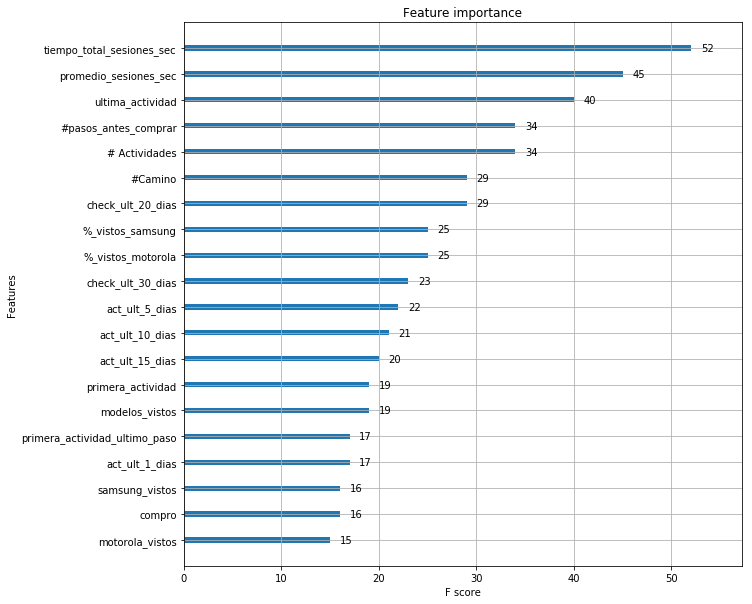

In [509]:
fig, ax = plt.subplots(figsize=(10,10))
plot_importance(clf, ax=ax, max_num_features = 20)
plt.show()

In [510]:
X, X_test, y, y_test = train_test_split(features, targets, test_size = 0.3, random_state = 5)
del X['person']
del X_test['person']

In [511]:
#81.04
X, X_test, y, y_test = train_test_split(features, targets, test_size = 0.3, random_state = 5)
del X['person']
del X_test['person']

eval_set = [(X, y), (X_test, y_test)]
eval_metric = ["auc","error"]
clf = xgb.XGBClassifier(silent=True, 
                      scale_pos_weight=1,
                      learning_rate=0.04,  
                      colsample_bytree = 0.9,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=600, 
                      reg_alpha = 0.3,
                      max_depth=4, 
                      gamma=10)
clf.fit(X, y, eval_metric=eval_metric, eval_set=eval_set, verbose=False)
y_pred = clf.predict(X_test)


In [512]:
y_test['pred'] = pd.Series(y_pred).values

In [513]:
confusion_matrix(y_test['label'], y_test['pred'])

array([[266,  63],
       [ 46, 243]], dtype=int64)

In [514]:
print (f1_score(y_test['label'], y_test['pred']))

0.8168067226890755


In [515]:
print (recall_score(y_test['label'], y_test['pred']))

0.8408304498269896


In [516]:
print (roc_auc_score(y_test['label'], y_test['pred']))


0.824670544062431


In [109]:
test = personas.merge(trainingData, on = 'person', how = 'left', indicator = True)

In [110]:
test = test.drop_duplicates(subset ='person', keep = 'last')

In [111]:
test = test[test['_merge'] == 'left_only']

In [112]:
del test['label']
del test['_merge']


In [113]:
test_X = test[list(X.columns.values)]

In [114]:
i = 0
for clf in clasificadores:
    columna = 'label_' + str(i)
    test_Y = clf.predict(test_X)
    test[columna] = pd.Series(test_Y).values
    i = i + 1 

In [123]:
test['label'] = test.iloc[:,-10:].mean(axis = 1)

In [124]:
test['label'] = test['label'] + 0.2

In [125]:
test['label'] = test['label'].round()

In [ ]:
test

In [126]:
test.iloc[:,-10:]

,label_1,label_2,label_3,label_4,label_5,label_6,label_7,label_8,label_9,label
1,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
5,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [127]:
date = str(datetime.datetime.now().strftime('%d_%m_%Y_%H_%M_%S'))
training_file_name = 'C:\\Users\\RAUL\\Documents\\OrgDatos2\\TP2\\Training Sets\\training_' + date + '.csv'
file_name = 'C:\\Users\\RAUL\\Documents\\OrgDatos2\\TP2\\Submits\\' + date + '.csv'

In [128]:
test[['person','label']].head()

,person,label
1,00091926,1.0
2,00091a7a,1.0
3,000ba417,1.0
5,000e4d9e,1.0
6,000e619d,0.0


In [129]:
training.to_csv(training_file_name)
test[['person','label']].to_csv(file_name, index = False)

In [130]:
test[['person','label']].shape

(19415, 2)

In [131]:
prueba = pd.read_csv('C:\\Users\\RAUL\\Documents\\OrgDatos2\\TP2\\Submits\\' + '09_10_2018_22_34_57.csv')

In [121]:
prueba.shape

(19415, 2)